In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.contingency import margins
from mpl_toolkits import mplot3d

### model

Datapoints $(x,t)$ are believed to come from a straight line with Gaussian noise $e \sim N(0, \sigma^2)$

$$
y = w_0 + w_1 x +  e,
$$


Now we want to infer the parameters $w_0, w_1$ with posterior sampling method

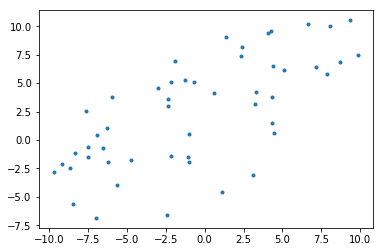

In [2]:
# Simulate points
w1 = 0.5 
w0 = 3
sigma2 = 3
N = 50
err = np.random.normal(0,sigma2,N)
X = np.array(sorted(np.random.uniform(-10,10,N)))
T = X*w1+w0+err



plt.plot(X,T,".")
plt.show()

Assuming uniform prior for $w_0$, $w_1$ from -10 to 10
* __Posterior:__
    \begin{aligned}
    P(w_0,w_1|D) 
    &\propto P(D|w_0,w_1)P(w_0,w_1)\\
    &\propto \int_{-10}^{+10} \int_{-10}^{10} \prod_i \sqrt{\frac 1 {2 \pi \sigma^2}}e^{\frac {-(t_i-w_0-w_1 x_i)^2} {2 \sigma^2}} \, dw_0 dw_1\\
    &\propto  \int_{-10}^{10}\int_{-10}^{10}  e^ {\sum_i -0.5\ln 2\pi \sigma^2 {+\frac {-(t_i-w_0-w_1 x_i)^2} {2\sigma^2}} }\, dw_0 dw_1\\
    \end{aligned}

In [3]:
def posterior(x, t, w0, w1,sigma2):
    
    logconst = -0.5*np.log(2*np.pi)*sigma2
    logP = 0        # flat prior
    logP = sum(-(t - w0 - w1*x)*(t - w0 - w1*x)/2/sigma2 + logconst)
    return np.exp(logP)



nbin   = 100
w0_min = -10
w0_max = +10
w1_min = -10
w1_max = +10

x0 = np.linspace(w0_min, w0_max, nbin) 
x1 = np.linspace(w1_min, w1_max, nbin)

def posterior_pdf(X,T):
    h2 = []
    H2 = 0
    bsize_w0 = (w0_max - w0_min)/nbin
    bsize_w1 = (w1_max - w1_min)/nbin
    for b0 in range(nbin):
        w0 = w0_min + b0*bsize_w0   
        row = []
        for b1 in range(nbin):
            w1 = w1_min + b1*bsize_w1  
            ev = posterior(X, T, w0, w1,sigma2) * bsize_w0 * bsize_w1
            H2 += ev
            row.append(ev)
        h2.append(row)

    # normalization
    h2  = np.array(h2)/np.sum(np.array(h2))


    idx = np.unravel_index(np.argmax(h2), np.array(h2).shape)
    w0_argmax_h2 = w0_min + idx[0]*bsize_w0
    w1_argmax_h2 = w1_min + idx[1]*bsize_w1      
    
    return h2


pdf = posterior_pdf(X,T)

### Marginalize this distribution 

In [4]:
def marginalization(pdf):
    pdf_w0,pdf_w1 = margins(pdf)
    pdf_w0 = pdf_w0.T

    cdf_w0 = np.cumsum(pdf_w0)
    cdf_w1 = np.cumsum(pdf_w1)
    return cdf_w0,cdf_w1

cdf_w0,cdf_w1 = marginalization(pdf)

### Sample for w0, w1

In [5]:
def parameters_sample(cdf_w0,cdf_w1):
    r = np.random.uniform(low=0.0, high=1.0, size=2)
    i = int(np.argwhere(cdf_w0>r[0])[0] -1)
    i = max(i,0)
    w0_sampled = x0[i]
    i = int(np.argwhere(cdf_w1>r[1])[0] -1)
    i = max(i,0)

    w1_sampled = x0[i]

    return w0_sampled,w1_sampled

### Plot the sampled line

w0:  2.3232323232323235  w1:  0.5050505050505052
w0:  2.7272727272727266  w1:  0.5050505050505052
w0:  2.525252525252524  w1:  0.5050505050505052
w0:  2.7272727272727266  w1:  0.5050505050505052
w0:  2.7272727272727266  w1:  0.5050505050505052


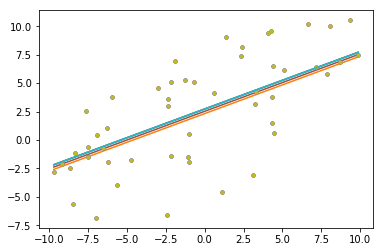

In [12]:
## sample and plot the line 5 times

def plot_sample(X,T,cdf_w0,cdf_w1):
    for i in range(5):
        w0_sampled,w1_sampled = parameters_sample(cdf_w0,cdf_w1)
        print("w0: ", w0_sampled," w1: ",w1_sampled)
        Y = []
        for i in range(len(X)):
            Y.append(w0_sampled + w1_sampled * X[i])

        plt.plot(X,T,".")
        plt.plot(X,Y)
    plt.show()
    
plot_sample(X,T,cdf_w0,cdf_w1)

### Let's use less points for the posterior
### First, randomly pick 10 points

w0:  2.929292929292929  w1:  0.5050505050505052
w0:  3.737373737373737  w1:  0.30303030303030276
w0:  3.1313131313131315  w1:  0.5050505050505052
w0:  2.3232323232323235  w1:  0.5050505050505052
w0:  3.333333333333334  w1:  0.5050505050505052


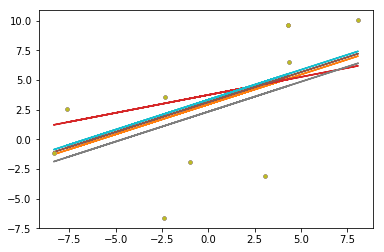

In [13]:
def sub_sampling(sub_idx):
    X1 = X[sub_idx]
    T1 = T[sub_idx]

    pdf1=posterior_pdf(X1,T1)
    cdf_w0_1,cdf_w1_1 = marginalization(pdf1)

    plot_sample(X1,T1,cdf_w0_1,cdf_w1_1)


sub_idx = np.random.choice(N, 10)
sub_sampling(sub_idx)

### Now let's try the points in the middle

w0:  3.1313131313131315  w1:  0.5050505050505052
w0:  2.7272727272727266  w1:  0.9090909090909083
w0:  2.7272727272727266  w1:  0.5050505050505052
w0:  3.1313131313131315  w1:  0.7070707070707076
w0:  3.5353535353535346  w1:  0.5050505050505052


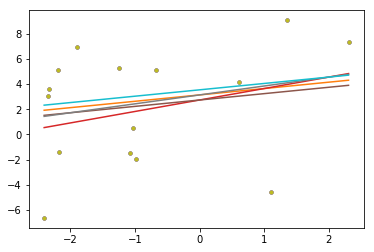

In [14]:
sub_idx = range(17,32)
sub_sampling(sub_idx)

### Next try points from the ends

w0:  -1.717171717171718  w1:  0.30303030303030276
w0:  2.929292929292929  w1:  0.30303030303030276
w0:  -1.3131313131313131  w1:  0.7070707070707076
w0:  -0.7070707070707076  w1:  0.10101010101010033
w0:  1.1111111111111107  w1:  0.5050505050505052


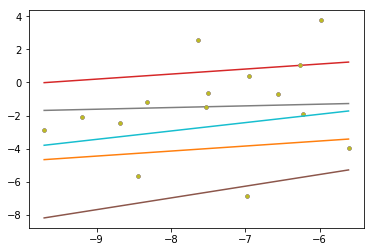

In [15]:
sub_idx = range(15)
sub_sampling(sub_idx)

w0:  2.929292929292929  w1:  0.7070707070707076
w0:  3.5353535353535346  w1:  0.9090909090909083
w0:  3.333333333333334  w1:  0.7070707070707076
w0:  2.7272727272727266  w1:  0.5050505050505052
w0:  2.929292929292929  w1:  0.7070707070707076


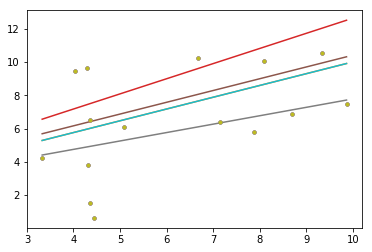

In [16]:
sub_idx = range(35,50)
sub_sampling(sub_idx)

w0:  3.5353535353535346  w1:  0.5050505050505052
w0:  3.5353535353535346  w1:  0.5050505050505052
w0:  3.333333333333334  w1:  0.5050505050505052
w0:  3.1313131313131315  w1:  0.5050505050505052
w0:  3.9393939393939394  w1:  0.5050505050505052


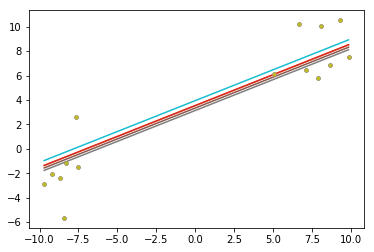

In [17]:
sub_idx = list(range(7))+list(range(42,50))
sub_sampling(sub_idx)

# Metropolis-hastings

From Wikipedia: "the Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult"
https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

Here in our case, the full posterior distribution is a 2D pdf, which is hard to sample directly.
The algorithm goes like follow:

* we start with some initial parameters $\Theta$ and calculating the probability with $\Theta$
* In each iterations:
    * modify the previous parameters by a small value
    * calculate the new probability with the new parameters
    * calculate the ratio $\alpha = \frac {P_{new}} {P_{prev}}$
    * if $\alpha > 1$, accept the new parameters
    * if $\alpha <1$, accept the new parameters with probability $\alpha$, reject otherwise
    
* Take the mean values of the parameters after convergence  

In [18]:
def log_posterior(x, t, w0, w1,sigma2):    
    logconst = -0.5*np.log(2*np.pi)*sigma2
    logP = 0        # flat prior
    logP = sum(-(t - w0 - w1*x)*(t - w0 - w1*x)/2/sigma2 + logconst)
    return logP



w0_prev = 0
w1_prev = 0


sub_idx = range(17,32)
X0 = X[sub_idx]
T0 = T[sub_idx]


posterior_prev=  log_posterior(X0, T0, w0_prev, w1_prev,sigma2)


iterations = 100000

w0_sampled = np.empty(iterations)
w1_sampled = np.empty(iterations)
for i in range(iterations):
    # draw a new set of parameters using previous value
    w0_cur = w0_prev+np.random.normal(0, 0.01)
    w1_cur = w1_prev+np.random.normal(0, 0.1)
    
    # calculate the posterior with the new parameters
    posterior_cur =  log_posterior(X0, T0, w0_cur, w1_cur,sigma2)
    
    #calculate the ratio 
    alpha = np.exp(posterior_cur-posterior_prev)

    if alpha>1: # accept the current 
        w0_prev = w0_cur
        w1_prev = w1_cur
        posterior_prev = posterior_cur
        
    elif np.random.uniform()<alpha: # accept with probability alpha
        w0_prev = w0_cur
        w1_prev = w1_cur
        posterior_prev = posterior_cur
        
    # Update the result arrays
    w0_sampled[i] = w0_prev
    w1_sampled[i] = w1_prev
    
        

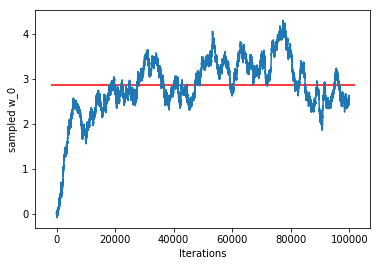

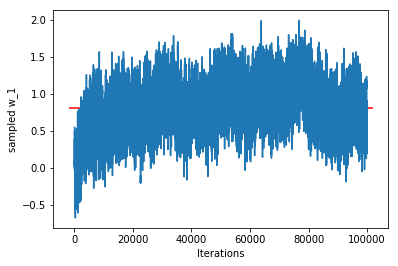

In [19]:
plt.plot(list(range(iterations)), w0_sampled)
plt.hlines(np.mean(w0_sampled[1000:]), -2000, iterations+2000, 'r')
plt.xlabel("Iterations")
plt.ylabel("sampled w_0")
plt.show()

plt.plot(list(range(iterations)), w1_sampled)
plt.hlines(np.mean(w1_sampled[1000:]), -2000, iterations+2000,'r')
plt.xlabel("Iterations")
plt.ylabel("sampled w_1")
plt.show()